# Import necessary modules

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = np.expand_dims(x_test, -1)

In [12]:
# Load MNIST test data
(_, _), (x_test, y_test) = mnist.load_data()
x_test = np.expand_dims(x_test, -1)  # (10000, 28, 28, 1)

# Select 10 samples per class
num_classes = 10
samples_per_class = 50

selected_images = []
selected_labels = []

for class_label in range(num_classes):
    # Get indices of images with the current class label
    indices = np.where(y_test == class_label)[0][:samples_per_class]
    
    selected_images.append(x_test[indices])
    selected_labels.append(y_test[indices])

# Stack into arrays
x_test_100 = np.concatenate(selected_images, axis=0)
y_test_100 = np.concatenate(selected_labels, axis=0)

print("Shape of selected images:", x_test_100.shape)  # (100, 28, 28, 1)
print("Shape of selected labels:", y_test_100.shape)  # (100,)


Shape of selected images: (500, 28, 28, 1)
Shape of selected labels: (500,)


In [13]:
x_test_100 = tf.image.grayscale_to_rgb(tf.convert_to_tensor(x_test_100))
x_test_100 = tf.image.resize(x_test_100, (224, 224))

In [14]:
x_test_100 = preprocess_input(x_test_100)

In [15]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
gap_output = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
feature_extractor = Model(inputs=base_model.input, outputs=gap_output)

In [16]:
features = feature_extractor.predict(x_test_100, batch_size=32, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step


In [17]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

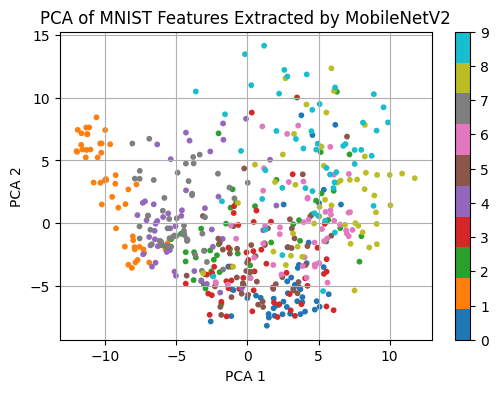

In [18]:
plt.figure(figsize=(6, 4))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=y_test_100, cmap="tab10", s=10)
plt.colorbar(scatter, ticks=range(10))
plt.title("PCA of MNIST Features Extracted by MobileNetV2")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

2025-06-18 08:44:24.306157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750214664.323160    6729 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750214664.328320    6729 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750214664.341791    6729 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750214664.341808    6729 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750214664.341810    6729 computation_placer.cc:177] computation placer alr

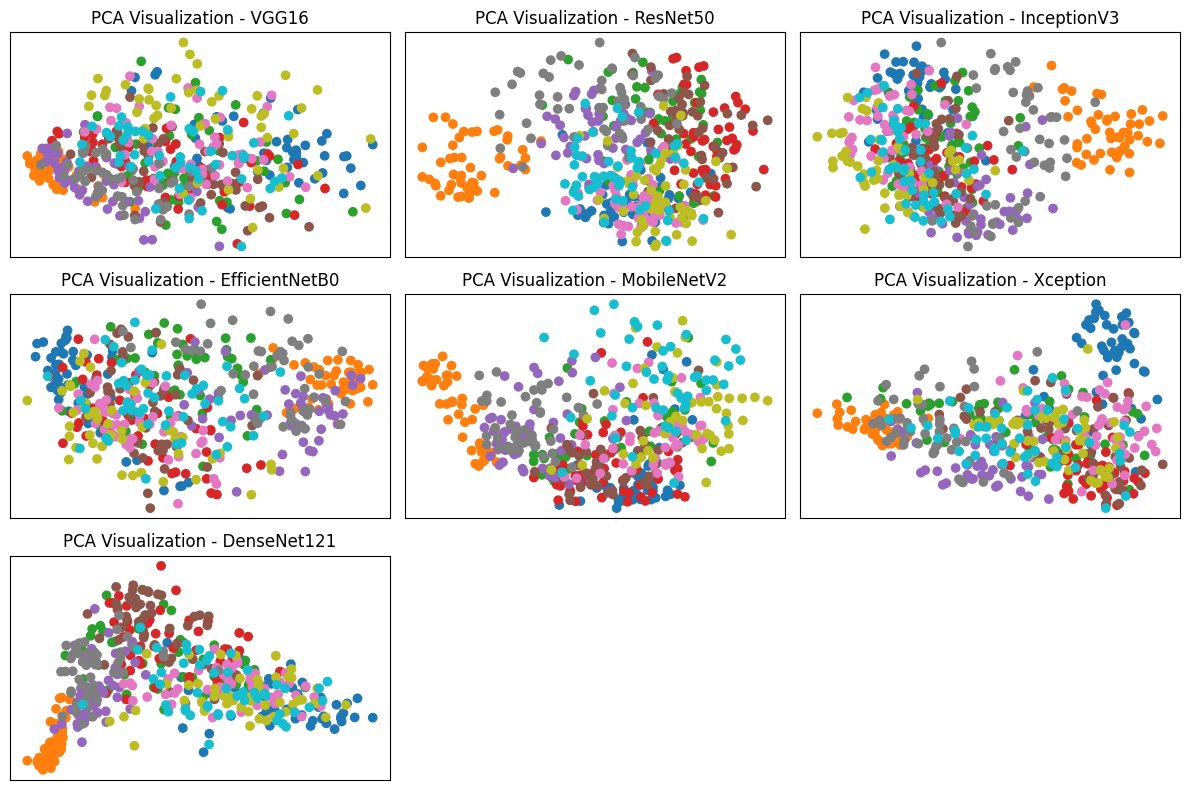

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow.keras.applications import (
    VGG16, ResNet50, InceptionV3, EfficientNetB0,
    MobileNetV2, Xception, DenseNet121
)
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_pre
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_pre
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_pre
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_pre
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_pre
from tensorflow.keras.applications.xception import preprocess_input as xception_pre
from tensorflow.keras.applications.densenet import preprocess_input as densenet_pre

# Load and filter MNIST test data (10 samples per class)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_test = np.expand_dims(x_test, -1)
selected_images = []
selected_labels = []

for class_idx in range(10):
    idxs = np.where(y_test == class_idx)[0][:50]
    selected_images.append(x_test[idxs])
    selected_labels.extend(y_test[idxs])

x_test_100 = np.concatenate(selected_images, axis=0)
y_test_100 = np.array(selected_labels)

# Resize and convert grayscale to RGB
x_test_rgb = tf.image.resize(x_test_100, (224, 224))
x_test_rgb = tf.image.grayscale_to_rgb(x_test_rgb)

# Define model/preprocess mappings
models = {
    "VGG16": (VGG16(include_top=False, input_shape=(224, 224, 3), pooling='avg'), vgg_pre),
    "ResNet50": (ResNet50(include_top=False, input_shape=(224, 224, 3), pooling='avg'), resnet_pre),
    "InceptionV3": (InceptionV3(include_top=False, input_shape=(224, 224, 3), pooling='avg'), inception_pre),
    "EfficientNetB0": (EfficientNetB0(include_top=False, input_shape=(224, 224, 3), pooling='avg'), efficientnet_pre),
    "MobileNetV2": (MobileNetV2(include_top=False, input_shape=(224, 224, 3), pooling='avg'), mobilenet_pre),
    "Xception": (Xception(include_top=False, input_shape=(224, 224, 3), pooling='avg'), xception_pre),
    "DenseNet121": (DenseNet121(include_top=False, input_shape=(224, 224, 3), pooling='avg'), densenet_pre),
}

# Prepare figure
fig, axs = plt.subplots(3, 3, figsize=(12, 8))
axs = axs.flatten()

# Extract and plot PCA features
for i, (model_name, (model, preprocess)) in enumerate(models.items()):
    x_preprocessed = preprocess(x_test_rgb.numpy())
    features = model.predict(x_preprocessed, verbose=0)
    
    pca = PCA(n_components=2)
    proj = pca.fit_transform(features)
    
    axs[i].scatter(proj[:, 0], proj[:, 1], c=y_test_100, cmap="tab10")
    axs[i].set_title(f"PCA Visualization - {model_name}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# Remove any unused subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [ ]:
# Train each model for 1 epoch to see a clear separation of features

Shape of selected images: (500, 28, 28)
Shape of selected labels: (500,)
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 1us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 308ms/step


C:\Users\Israil\AppData\Local\Temp\ipykernel_12100\3301361490.py:54: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=x_input)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/3
29/29 - 11s - 392ms/step - accuracy: 0.2589 - loss: 2.5965 - val_accuracy: 0.4200 - val_loss: 1.7254
Epoch 2/3
29/29 - 4s - 147ms/step - accuracy: 0.6000 - loss: 1.3044 - val_accuracy: 0.6200 - val_loss: 1.1073
Epoch 3/3
29/29 - 5s - 160ms/step - accuracy: 0.7111 - loss: 0.9716 - val_accuracy: 0.6300 - val_loss: 1.0229
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 400ms/step


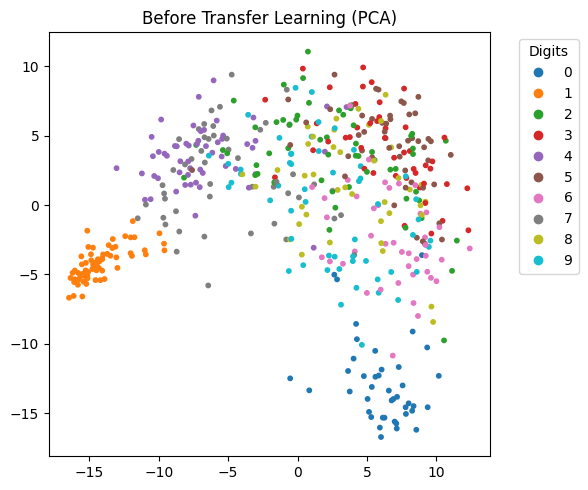

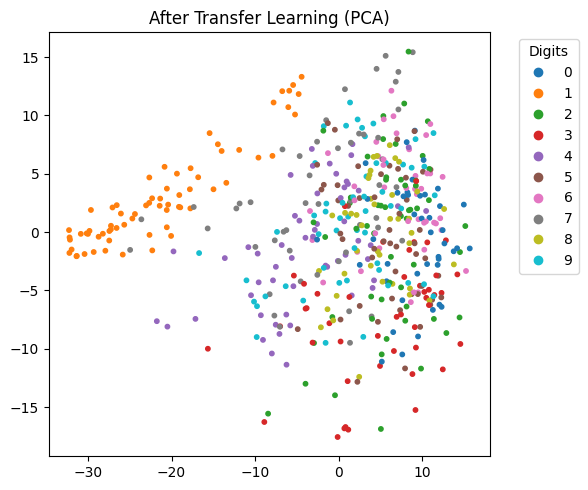

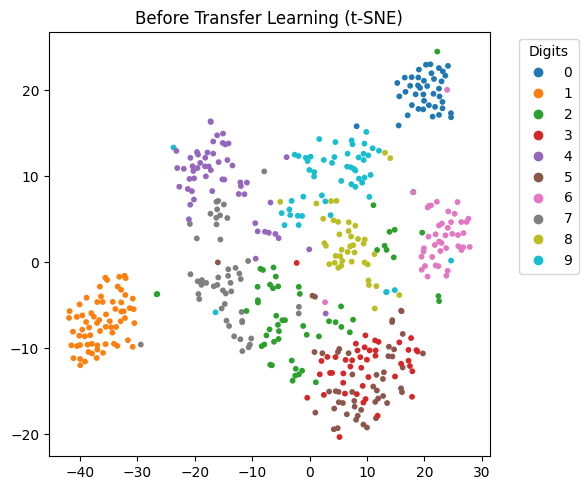

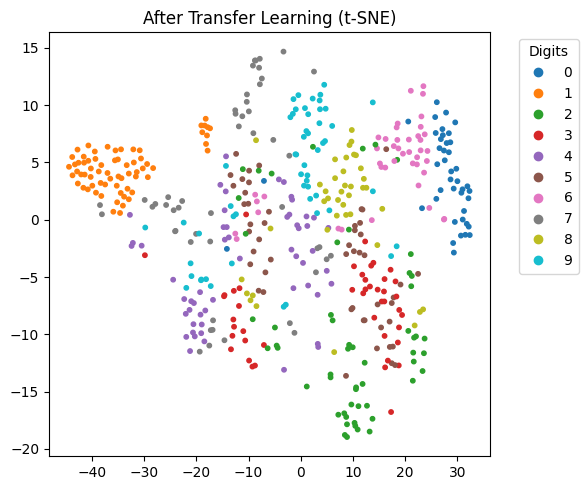

c:\Users\Israil\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


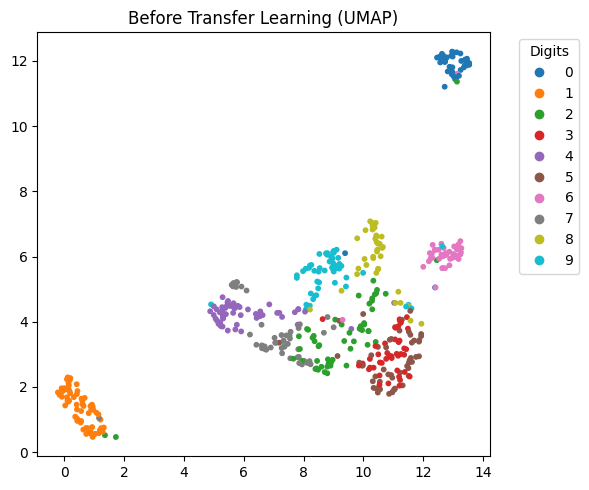

c:\Users\Israil\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


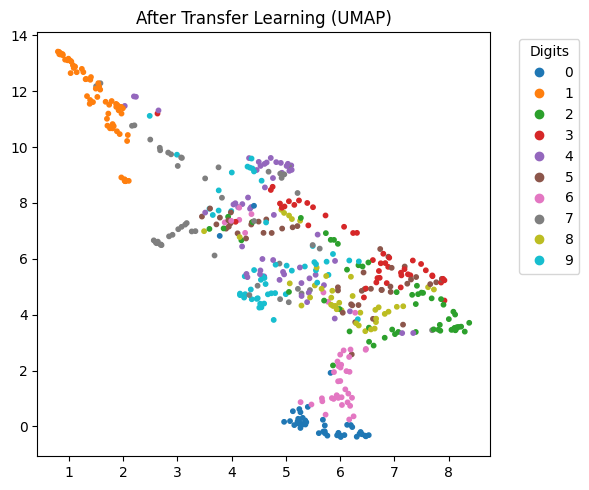

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Limit GPU memory growth (optional)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except:
        pass

# 1. Load and preprocess MNIST dataset (smaller subset)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Take small subset for quick test and low memory
x_train, y_train = x_train[:1000], y_train[:1000]
x_test, y_test = x_test[:500], y_test[:500]

print("Shape of selected images:", x_test.shape)
print("Shape of selected labels:", y_test.shape)

# Expand dims to (batch, 28, 28, 1), convert to RGB and resize to (96, 96, 3)
def preprocess(images):
    images = tf.expand_dims(images, -1)
    images = tf.image.grayscale_to_rgb(images)
    images = tf.image.resize(images, [96, 96])
    return images / 255.0

x_train = preprocess(x_train).numpy()
x_test = preprocess(x_test).numpy()
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# 2. Load pretrained MobileNetV2 (ImageNet weights) as feature extractor
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False
model_before = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Extract features BEFORE transfer learning
features_before = model_before.predict(x_test, verbose=1)

# 3. Fine-tune on MNIST
x_input = Input(shape=(96, 96, 3))
base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=x_input)
base.trainable = False
x = GlobalAveragePooling2D()(base.output)
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax')(x)
model_after = Model(inputs=x_input, outputs=output)
model_after.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train with small batch size and fewer epochs
model_after.fit(x_train, y_train_cat, epochs=3, batch_size=32, validation_split=0.1, verbose=2)

# Extract features AFTER transfer learning
feature_extractor_after = Model(inputs=model_after.input, outputs=model_after.layers[-3].output)
features_after = feature_extractor_after.predict(x_test, verbose=1)

# 4. Dimensionality reduction and plotting
def plot_2d(features, labels, method, title):
    if method == 'PCA':
        reducer = PCA(n_components=2)
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'UMAP':
        reducer = umap.UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("Invalid method")

    reduced = reducer.fit_transform(features)
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', s=10)
    plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plotting for each method
for method in ['PCA', 't-SNE', 'UMAP']:
    plot_2d(features_before, y_test, method, f"Before Transfer Learning ({method})")
    plot_2d(features_after, y_test, method, f"After Transfer Learning ({method})")
